In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset, ConcatDataset
import numpy as np
import matplotlib.pyplot as plt
import yaml
from tqdm import tqdm
import torchvision.transforms.v2 as v2
from copy import deepcopy
import sys
sys.path.append("/n/home11/sambt/phlab-neurips25")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

from models.litmodels import SimCLRModel
from models.networks import CustomResNet, MLP
from models.losses import MMDLoss, RBF
from data.datasets import CIFAR10Dataset
from data.cifar import CIFAR5MDataset
import data.data_utils as dutils

from sklearn.metrics import roc_auc_score, top_k_accuracy_score
from utils.plotting import make_corner

/n/holystore01/LABS/iaifi_lab/Users/sambt/mamba/envs/torch_gpu/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
#CHECKPOINT = '/n/home11/sambt/phlab-neurips25/runs/cifar10_simCLR_ResNet50_T0.5/lightning_logs/o1t4hdp7/checkpoints/epoch=8-step=441.ckpt'
#CHECKPOINT = '/n/home11/sambt/phlab-neurips25/runs/cifar10_simCLR_ResNet50_T0.5/lightning_logs/qdcc0he3/checkpoints/epoch=15-step=1408.ckpt'
CHECKPOINT = "/n/home11/sambt/phlab-neurips25/runs/cifar10_simCLR_ResNet50_T0.1_dim4_exclude0/lightning_logs/2xpzevgs/checkpoints/epoch=3-step=352.ckpt"
EXCLUDE_CLASSES = [0]

# evaluate pre-trained model; train classifier on embeddings

In [3]:
cifar = CIFAR10Dataset("resnet50",num_workers=2,batch_size=1024,exclude_classes=EXCLUDE_CLASSES)
cifar_train_dataset = cifar.train_dataset
cifar_test_dataset = cifar.test_dataset

#hue_transform = v2.ColorJitter(hue=(-0.2,-0.2))
#cifar5m_full = CIFAR5MDataset("resnet50",[0],[(None,50_000)],grayscale=False,custom_pre_transforms=[hue_transform])
cifar5m_full = CIFAR5MDataset("resnet50",[0],[(None,None)],grayscale=True,exclude_classes=EXCLUDE_CLASSES)

model = SimCLRModel.load_from_checkpoint(CHECKPOINT)
model = model.to(device)
model = model.eval()

EXCLUDING CLASSES: [0]


/n/holystore01/LABS/iaifi_lab/Users/sambt/mamba/envs/torch_gpu/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/n/holystore01/LABS/iaifi_lab/Users/sambt/mamba/envs/torch_gpu/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.


In [6]:
# embed cifar train/test set using pre-trained model
cifar_embeds = []
cifar_labels = []
cifar_train_embeds = []
cifar_train_labels = []

for ims,labs in tqdm(DataLoader(cifar_test_dataset,batch_size=1024,shuffle=False)):
    with torch.no_grad():
        cifar_embeds.append(model.encoder(ims.to(device)).cpu().numpy())
        cifar_labels.append(labs.numpy()) 
        
for ims,labs in tqdm(DataLoader(cifar_train_dataset,batch_size=1024,shuffle=False)):
    with torch.no_grad():
        cifar_train_embeds.append(model.encoder(ims.to(device)).cpu().numpy())
        cifar_train_labels.append(labs.numpy()) 
        
cifar_embeds = np.concatenate(cifar_embeds)
cifar_labels = np.concatenate(cifar_labels)
cifar_train_embeds = np.concatenate(cifar_train_embeds)
cifar_train_labels = np.concatenate(cifar_train_labels)

100%|██████████| 44/44 [01:44<00:00,  2.37s/it]


In [7]:
#classifier = torch.load("cifar10_classifier_initialEmbedding.pt").to(device)
classifier = model.classifier

In [30]:
cifar5m_embeds = []
cifar5m_labels = []
cifar5m_preds = []

for ims,labs in tqdm(DataLoader(cifar5m_full,batch_size=4096,shuffle=False)):
    with torch.no_grad():
        cifar5m_embeds.append(model.encoder(ims.to(device)).cpu().numpy())
        cifar5m_labels.append(labs.numpy())
        cifar5m_preds.append(classifier(torch.tensor(cifar5m_embeds[-1]).to(device)).cpu().numpy())

100%|██████████| 220/220 [20:41<00:00,  5.64s/it]


In [32]:
cifar5m_embeds = np.concatenate(cifar5m_embeds)
cifar5m_labels = np.concatenate(cifar5m_labels)
cifar5m_preds = np.concatenate(cifar5m_preds)

In [33]:
np.save("cifar5m_classifierPreds_grayScale_file0.npy",cifar5m_preds)
np.save("cifar5m_embeds_grayScale_file0.npy",cifar5m_embeds)
np.save("cifar5m_labels_grayScale_file0.npy",cifar5m_labels)

In [9]:
cifar5m_embeds = np.concatenate(cifar5m_embeds)
cifar5m_labels = np.concatenate(cifar5m_labels)
cifar5m_preds = np.concatenate(cifar5m_preds)
#np.save("cifar5m_classifierPreds_first1M_file0.npy",cifar5m_preds)
#np.save("cifar5m_embeds_first1M_file0.npy",cifar5m_embeds)
#np.save("cifar5m_labels_first1M_file0.npy",cifar5m_labels)


cifar_preds = []
for x in tqdm(DataLoader(TensorDataset(torch.tensor(cifar_embeds)),batch_size=1024,shuffle=False)):
    with torch.no_grad():
        cifar_preds.append(classifier(x[0].to(device)).cpu().numpy())
cifar_preds = np.concatenate(cifar_preds)

100%|██████████| 9/9 [00:00<00:00, 304.12it/s]


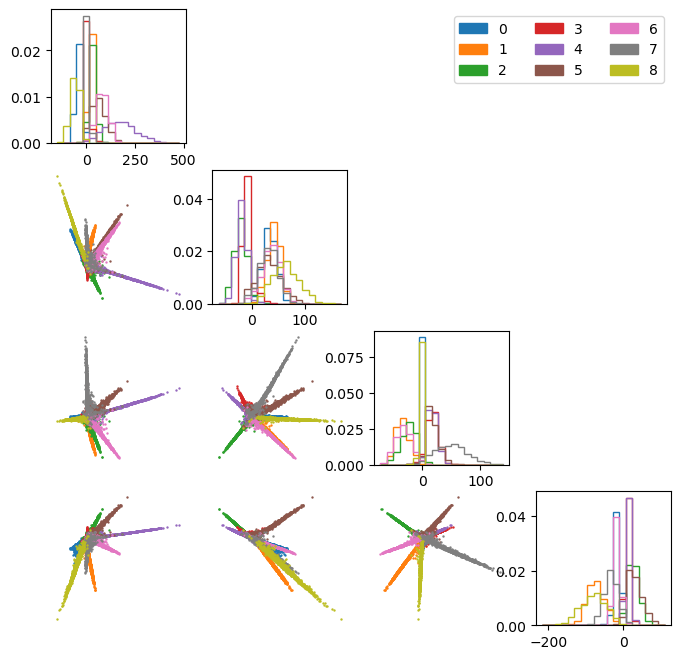

In [10]:
make_corner(cifar_embeds,cifar_labels)

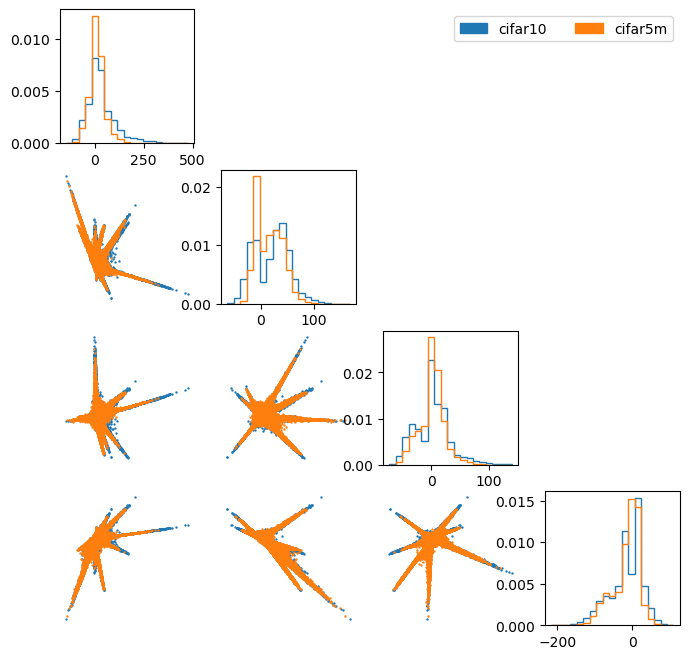

In [24]:
regular = cifar_embeds
shift = cifar5m_embeds
make_corner(np.concatenate([regular,shift],axis=0),
            labels=np.concatenate([np.zeros(len(regular)),np.ones(len(shift))]),
            label_names={0:"cifar10",1:"cifar5m"})

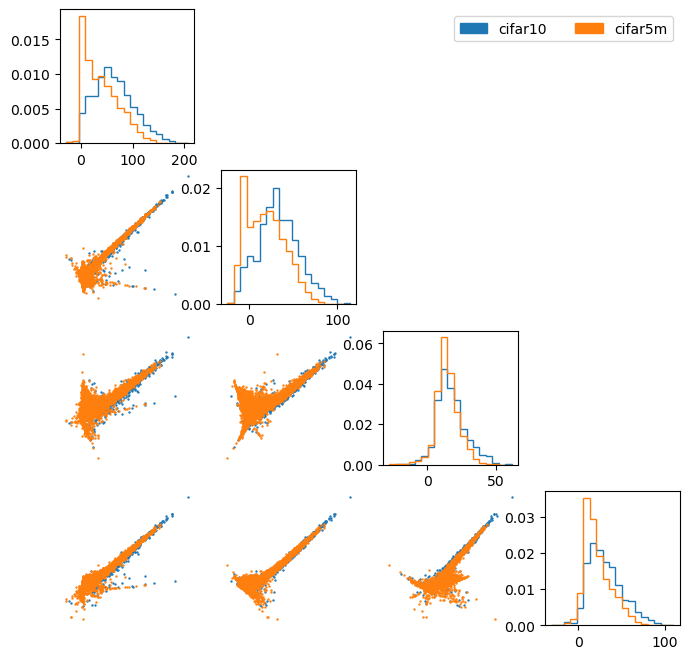

In [28]:
sel_label=5
regular = cifar_embeds[cifar_labels==sel_label]
shift = cifar5m_embeds[cifar5m_labels==sel_label]
make_corner(np.concatenate([regular,shift],axis=0),
            labels=np.concatenate([np.zeros(len(regular)),np.ones(len(shift))]),
            label_names={0:"cifar10",1:"cifar5m"})

In [14]:
probs_cifar5m = F.softmax(torch.tensor(cifar5m_preds),dim=1).numpy()
probs_cifar = F.softmax(torch.tensor(cifar_preds),dim=1).numpy()

In [15]:
print("Embedding space classifier metrics for CIFAR10 test set")
auc = roc_auc_score(cifar_labels,probs_cifar,multi_class='ovr')
print("OVR auc = ",auc)
auc = roc_auc_score(cifar_labels,probs_cifar,multi_class='ovo')
print("OVO auc = ",auc)
for k in range(1,6):
    topk = top_k_accuracy_score(cifar_labels,probs_cifar,k=k)
    print(f"Top {k} acc = ",topk)

Embedding space classifier metrics for CIFAR10 test set
OVR auc =  0.9945145277777778
OVO auc =  0.9945145277777778
Top 1 acc =  0.9295555555555556
Top 2 acc =  0.9697777777777777
Top 3 acc =  0.9808888888888889
Top 4 acc =  0.9867777777777778
Top 5 acc =  0.9933333333333333


In [16]:
print("Embedding space classifier metrics for CIFAR5m tiny set")
auc = roc_auc_score(cifar5m_labels,probs_cifar5m,multi_class='ovr')
print("OVR auc = ",auc)
auc = roc_auc_score(cifar5m_labels,probs_cifar5m,multi_class='ovo')
print("OVO auc = ",auc)
for k in range(1,6):
    topk = top_k_accuracy_score(cifar5m_labels,probs_cifar5m,k=k)
    print(f"Top {k} acc = ",topk)

Embedding space classifier metrics for CIFAR5m tiny set
OVR auc =  0.9653200225543874
OVO auc =  0.9644815587080608
Top 1 acc =  0.8024913402611245
Top 2 acc =  0.8821831423749888
Top 3 acc =  0.9148903099742428
Top 4 acc =  0.9362732036592948
Top 5 acc =  0.9521493915978329


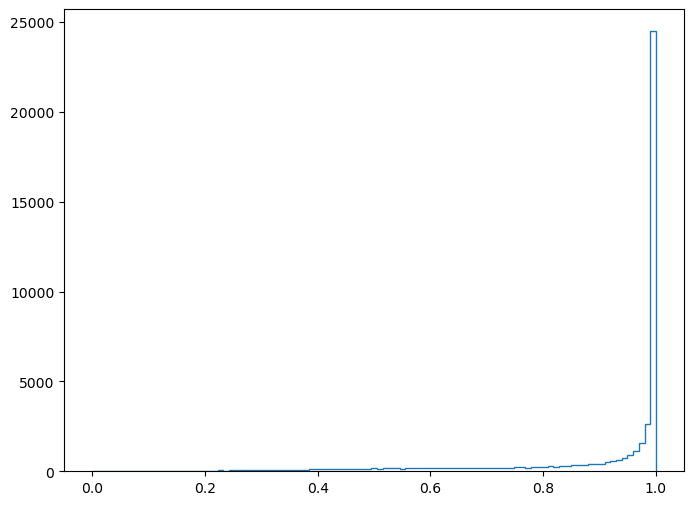

In [17]:
top_probs_cifar5m = np.max(probs_cifar5m,axis=1)
cifar5m_pred_classes = np.argmax(probs_cifar5m,axis=1)
plt.figure(figsize=(8,6))
h,bins,_ = plt.hist(top_probs_cifar5m,bins=np.linspace(0,1,100),histtype='step',density=False)

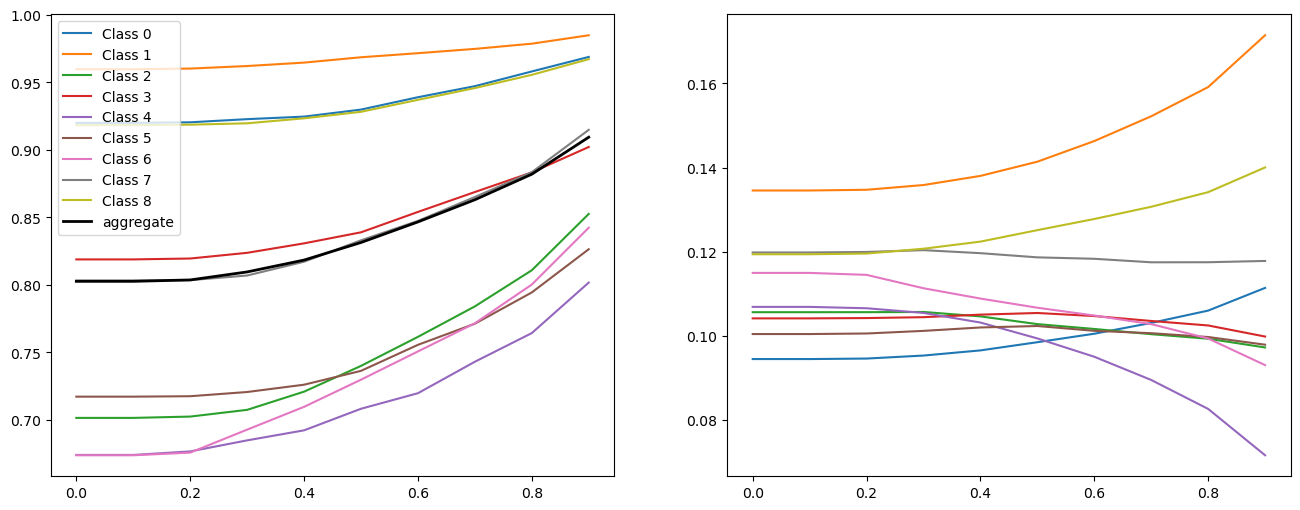

In [21]:
thresholds = np.arange(0,1,0.1)
fracs = {c:[] for c in range(9)}
breakdowns = {c:[] for c in range(9)}
totalFracs = []
for t in thresholds:
    cut = top_probs_cifar5m > t
    f_correct = np.count_nonzero(cifar5m_pred_classes[cut] == cifar5m_labels[cut]) / np.count_nonzero(cut)
    totalFracs.append(f_correct)
    for c in range(9):
        cut2 = cut & (cifar5m_labels == c)
        N = np.count_nonzero(cut2)
        fc = np.count_nonzero(cifar5m_pred_classes[cut2] == cifar5m_labels[cut2])/N
        fracs[c].append(fc)
        breakdowns[c].append(N/np.count_nonzero(cut))

        
fig,axes = plt.subplots(1,2,figsize=(16,6))
for c in range(9):
    plt.sca(axes[0])
    plt.plot(thresholds,fracs[c],label=f"Class {c}")
    plt.sca(axes[1])
    plt.plot(thresholds,breakdowns[c],label=f"Class {c}")
plt.sca(axes[0])
plt.plot(thresholds,totalFracs,lw=2,color='k',label="aggregate")
plt.legend()

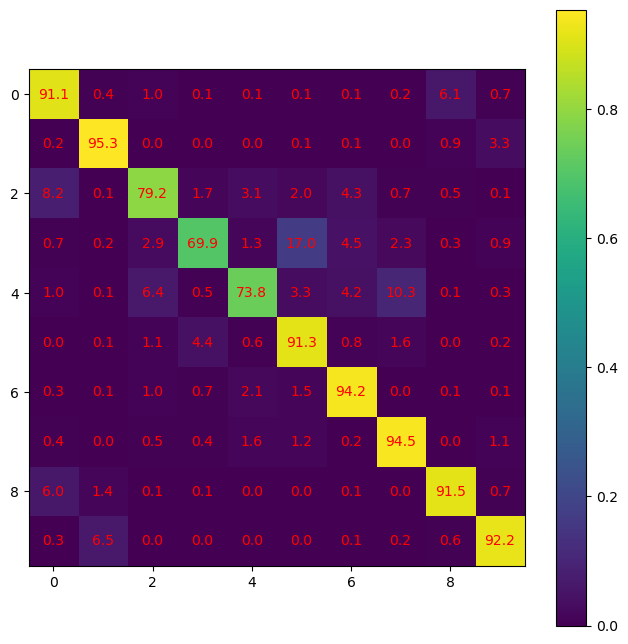

In [18]:
from sklearn.metrics import confusion_matrix
cut = top_probs_cifar5m > 0.8
mtx = confusion_matrix(cifar5m_labels[cut],cifar5m_pred_classes[cut],normalize='true')
plt.figure(figsize=(8,8))
plt.imshow(mtx)
plt.colorbar()
ax = plt.gca()
for i in range(mtx.shape[0]):
    for j in range(mtx.shape[1]):
        ax.text(j, i, f"{100*mtx[i, j]:.1f}",
                ha="center", va="center", color="red")

In [ ]:
cifar5m_finetune_dset = cifar5m_full.subselection(top_probs_cifar5m > 0.5)
cifar5m_finetune_train, cifar5m_finetune_test = cifar5m_finetune_dset.random_split(0.8)

In [ ]:
h=plt.hist(cifar5m_finetune_train.dataset[1],bins=np.arange(-0.5,10.5),histtype='step',density=True)
h=plt.hist(cifar5m_finetune_test.dataset[1],bins=np.arange(-0.5,10.5),histtype='step',density=True)

# fine tune v1: backbone only

In [33]:
model = SimCLRModel.load_from_checkpoint(CHECKPOINT)

In [4]:
cifar = CIFAR10Dataset("resnet50",exclude_classes=EXCLUDE_CLASSES,num_workers=2,batch_size=1024)
cifar_train_dataset = cifar.train_dataset
cifar_test_dataset = cifar.test_dataset

cifar5m_full = CIFAR5MDataset("resnet50",[0],[(None,100_000)],exclude_classes=EXCLUDE_CLASSES,
                              grayscale=True)

EXCLUDING CLASSES: [0]


In [5]:
cifar5m_finetune_train = cifar5m_full.subset(None,10_000)

# limit to 10k test images for now
cifar5m_finetune_test = cifar5m_full.subset(10_000,20_000)

In [6]:
# create embeddings using initial model for later comparison
model = model.eval()

cifar_embeds_pretune = []
cifar_labels_pretune = []
for batch in tqdm(DataLoader(cifar_test_dataset,batch_size=1024,shuffle=True,num_workers=2)):
    x,labels = batch
    with torch.no_grad():
        cifar_embeds_pretune.append(model.encoder(x.to(device)).cpu().numpy())
        cifar_labels_pretune.append(labels.numpy())
cifar_embeds_pretune = np.concatenate(cifar_embeds_pretune)
cifar_labels_pretune = np.concatenate(cifar_labels_pretune)


cifar5m_test_embed_pretune = []
cifar5m_test_labels_pretune = []
for batch in tqdm(DataLoader(cifar5m_finetune_test,batch_size=1024,shuffle=True,num_workers=2)):
    x,labels = batch
    with torch.no_grad():
        cifar5m_test_embed_pretune.append(model.encoder(x.to(device)).cpu().numpy())
        cifar5m_test_labels_pretune.append(labels.numpy())
cifar5m_test_embed_pretune = np.concatenate(cifar5m_test_embed_pretune)
cifar5m_test_labels_pretune = np.concatenate(cifar5m_test_labels_pretune)

100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


In [7]:
torch.cuda.empty_cache()

100it [01:01,  1.63it/s]
37it [00:19,  1.86it/s]

Epoch 37, Train: 0.56422, Val:0.57684
	 Train (simclr): 5.18540, Val (simclr):5.55301
	 Train (class): 0.00000, Val (class):0.00000
	 Train (domain): 0.00000, Val (domain):0.00000
	 Train (mmd): 0.04568, Val (mmd):0.02154



100it [01:00,  1.64it/s]
37it [00:19,  1.89it/s]

Epoch 37, Train: 0.54563, Val:0.57960
	 Train (simclr): 5.14665, Val (simclr):5.54900
	 Train (class): 0.00000, Val (class):0.00000
	 Train (domain): 0.00000, Val (domain):0.00000
	 Train (mmd): 0.03097, Val (mmd):0.02470



100it [01:00,  1.66it/s]
37it [00:19,  1.87it/s]

Epoch 37, Train: 0.54525, Val:0.57371
	 Train (simclr): 5.13160, Val (simclr):5.54753
	 Train (class): 0.00000, Val (class):0.00000
	 Train (domain): 0.00000, Val (domain):0.00000
	 Train (mmd): 0.03209, Val (mmd):0.01896



100it [01:01,  1.63it/s]
37it [00:20,  1.80it/s]

Epoch 37, Train: 0.54736, Val:0.57289
	 Train (simclr): 5.12323, Val (simclr):5.53257
	 Train (class): 0.00000, Val (class):0.00000
	 Train (domain): 0.00000, Val (domain):0.00000
	 Train (mmd): 0.03504, Val (mmd):0.01963



100it [01:03,  1.58it/s]
37it [00:20,  1.84it/s]

Epoch 37, Train: 0.54780, Val:0.57906
	 Train (simclr): 5.11001, Val (simclr):5.53596
	 Train (class): 0.00000, Val (class):0.00000
	 Train (domain): 0.00000, Val (domain):0.00000
	 Train (mmd): 0.03680, Val (mmd):0.02546



100it [01:01,  1.63it/s]
37it [00:20,  1.82it/s]

Epoch 37, Train: 0.54110, Val:0.57524
	 Train (simclr): 5.09143, Val (simclr):5.53512
	 Train (class): 0.00000, Val (class):0.00000
	 Train (domain): 0.00000, Val (domain):0.00000
	 Train (mmd): 0.03195, Val (mmd):0.02173



100it [01:00,  1.66it/s]
37it [00:19,  1.86it/s]

Epoch 37, Train: 0.54454, Val:0.58026
	 Train (simclr): 5.08806, Val (simclr):5.54154
	 Train (class): 0.00000, Val (class):0.00000
	 Train (domain): 0.00000, Val (domain):0.00000
	 Train (mmd): 0.03574, Val (mmd):0.02611



100it [01:01,  1.64it/s]
37it [00:20,  1.81it/s]

Epoch 37, Train: 0.54164, Val:0.57762
	 Train (simclr): 5.07712, Val (simclr):5.53374
	 Train (class): 0.00000, Val (class):0.00000
	 Train (domain): 0.00000, Val (domain):0.00000
	 Train (mmd): 0.03393, Val (mmd):0.02425



100it [01:00,  1.64it/s]
37it [00:19,  1.87it/s]

5 epochs of no improvement, stopping


Text(0.5, 1.0, 'MMD Loss')

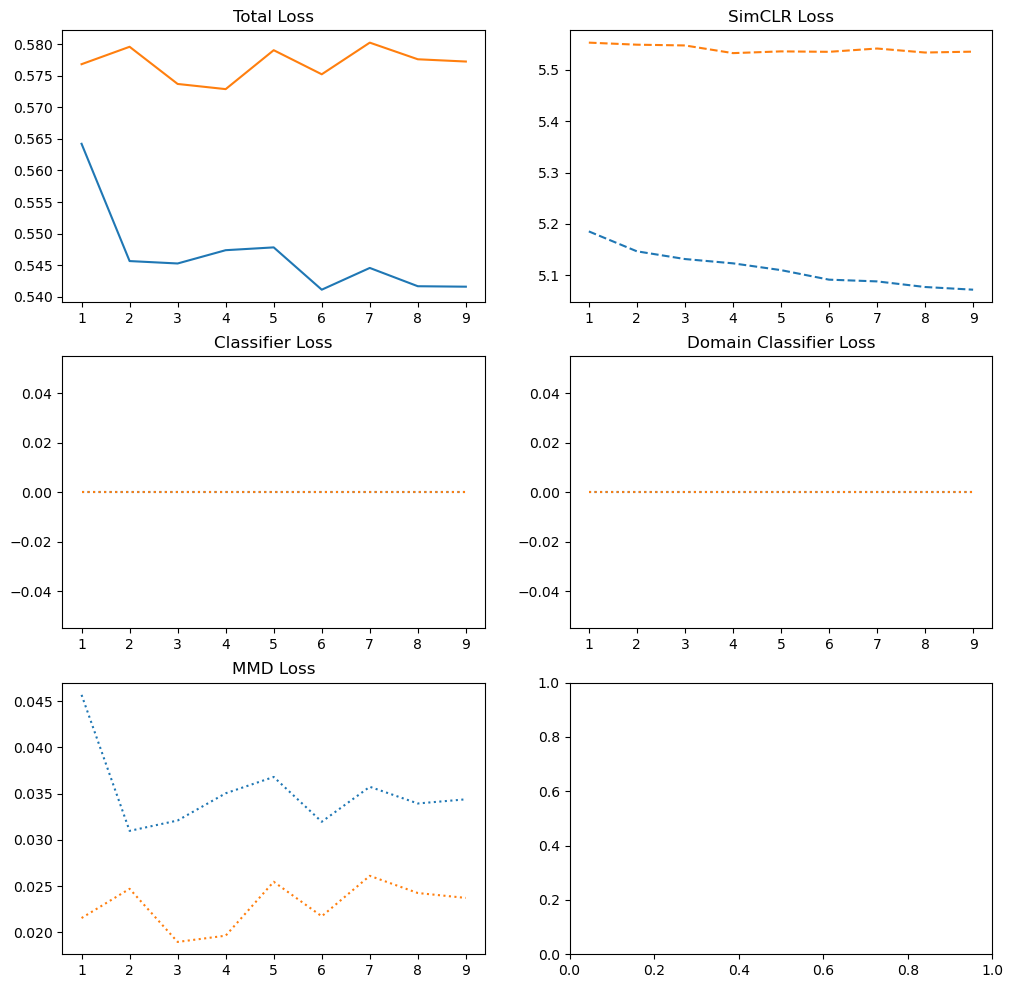

In [34]:
from models.losses import SupervisedSimCLRLoss

num_epoch = 10
patience_thresh = 5
criterion = model.simclr_criterion
mmd = MMDLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=num_epoch,eta_min=1e-5)

best_state = None
all_states = []
best_loss = 9999
patience = 0
train_losses = []
val_losses = []
train_simclr_losses = []
train_class_losses = []
train_domain_losses = []
train_mmd_losses = []
val_simclr_losses = []
val_class_losses = []
val_domain_losses = []
val_mmd_losses = []

train_loader = DataLoader(dutils.ConcatWithLabels([cifar_train_dataset,cifar5m_finetune_train],[0,1]),
                          batch_size=512,shuffle=True,num_workers=2,drop_last=True)
val_loader = DataLoader(dutils.ConcatWithLabels([cifar_test_dataset,cifar5m_finetune_test],[0,1]),
                        batch_size=512,shuffle=True,num_workers=2,drop_last=True)


model = model.train()
lambda_simclr = 0.1
lambda_class = 0.0
lambda_domain = 0.0
lambda_mmd = 1.0
for i in range(num_epoch):
    losses = []
    losses_simclr = []
    losses_class = []
    losses_domain = []
    losses_mmd = []
    max_batches = 100
    for i,batch in tqdm(enumerate(train_loader)):
        if i >= max_batches:
            break
        x,dset_label = batch
        x,labels = x
        
        h = model.encoder(x.to(device))
        #preds = model.classifier((h-embed_mean)/embed_std)
        #domain_preds = domain_classifier((h-embed_mean)/embed_std)
        z = model.projector(h)
        z = F.normalize(z,dim=1).unsqueeze(1) # normalize the projection for simclr loss
        
        #domain_labels = (dset_label==1).float().to(device).unsqueeze(1)
        #pos_mask = (labels.unsqueeze(1) == labels.unsqueeze(1).T).to(device) & (domain_labels != domain_labels.T)
        
        loss_simclr = criterion(z, labels=labels)
        #loss_simclr = criterion(z, mask=pos_mask)
        #loss_class = F.cross_entropy(preds,labels.to(device))
        loss_class = 0
        #loss_domain = F.binary_cross_entropy_with_logits(domain_preds,domain_labels)
        loss_domain = 0
        #h = (h-embed_mean)/embed_std
        loss_mmd = mmd(h[(dset_label==0).to(device)],h[(dset_label==1).to(device)])
        
        #loss = loss_simclr + lambda_class*loss_class + lambda_domain*loss_domain
        #loss = loss_simclr + lambda_class*loss_class
        #loss = loss_simclr + lambda_domain*loss_domain
        loss = lambda_simclr*loss_simclr + lambda_domain*loss_domain + lambda_class*loss_class + lambda_mmd*loss_mmd
        
        #loss = loss_class
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        losses_simclr.append(loss_simclr.item())
        losses_class.append(loss_class.item() if loss_class != 0 else loss_class)
        losses_domain.append(loss_domain.item() if loss_domain != 0 else loss_domain)
        losses_mmd.append(loss_mmd.item() if loss_mmd != 0 else loss_mmd)
    train_losses.append(np.mean(losses))
    train_simclr_losses.append(np.mean(losses_simclr))
    train_class_losses.append(np.mean(losses_class))
    train_domain_losses.append(np.mean(losses_domain))
    train_mmd_losses.append(np.mean(losses_mmd))
    
    losses = []
    losses_simclr = []
    losses_class = []
    losses_domain = []
    losses_mmd = []
    aucs = []
    max_batches_val = 100
    for i,batch in tqdm(enumerate(val_loader)):
        if i >= max_batches_val:
            break
        x,dset_label = batch
        x,labels = x
        with torch.no_grad():
            h = model.encoder(x.to(device))
            #preds = model.classifier((h-embed_mean)/embed_std)
            #domain_preds = domain_classifier((h-embed_mean)/embed_std)
            z = model.projector(h)
            z = F.normalize(z,dim=1).unsqueeze(1) # normalize the projection for simclr loss
            
            #domain_labels = (dset_label==1).float().to(device).unsqueeze(1)
            #pos_mask = (labels.unsqueeze(1) == labels.unsqueeze(1).T).to(device) & (domain_labels != domain_labels.T)
            
            loss_simclr = criterion(z, labels=labels)
            #loss_simclr = criterion(z, mask=pos_mask)
            #loss_class = F.cross_entropy(preds,labels.to(device))
            loss_class = 0
            #loss_domain = F.binary_cross_entropy_with_logits(domain_preds,domain_labels)
            loss_domain = 0
            #h = (h-embed_mean)/embed_std
            loss_mmd = mmd(h[(dset_label==0).to(device)],h[(dset_label==1).to(device)])
            
            #loss = loss_simclr + lambda_class*loss_class + lambda_domain*loss_domain
            #loss = loss_simclr + lambda_class*loss_class
            #loss = loss_simclr + lambda_domain*loss_domain
            #loss = loss_simclr
            #loss = loss_class
            loss = lambda_simclr*loss_simclr + lambda_domain*loss_domain + lambda_class*loss_class + lambda_mmd*loss_mmd
            
            losses.append(loss.item())
            losses_simclr.append(loss_simclr.item())
            losses_class.append(loss_class.item() if loss_class != 0 else loss_class)
            losses_domain.append(loss_domain.item() if loss_domain != 0 else loss_domain)
            losses_mmd.append(loss_mmd.item() if loss_mmd != 0 else loss_mmd)
            #aucs.append(roc_auc_score(domain_labels.cpu().numpy()[:,0],torch.sigmoid(preds).cpu().numpy()[:,0]))
    losses = np.mean(losses)
    val_losses.append(losses)
    val_simclr_losses.append(np.mean(losses_simclr))
    val_class_losses.append(np.mean(losses_class))
    val_domain_losses.append(np.mean(losses_domain))
    val_mmd_losses.append(np.mean(losses_mmd))
    if losses < best_loss:
        best_loss = losses
        best_state = model.state_dict()
        patience = 0
    else:
        patience += 1
        if patience == patience_thresh:
            print(f"{patience_thresh} epochs of no improvement, stopping")
            break
    all_states.append(model.state_dict())
        
    scheduler.step()
    
    #pbar.set_postfix_str(f"Train: {train_losses[-1]:.5f}, Val:{val_losses[-1]:.5f}")
    print(f"Epoch {i+1}, Train: {train_losses[-1]:.5f}, Val:{val_losses[-1]:.5f}")
    print(f"\t Train (simclr): {train_simclr_losses[-1]:.5f}, Val (simclr):{val_simclr_losses[-1]:.5f}")
    print(f"\t Train (class): {train_class_losses[-1]:.5f}, Val (class):{val_class_losses[-1]:.5f}")
    print(f"\t Train (domain): {train_domain_losses[-1]:.5f}, Val (domain):{val_domain_losses[-1]:.5f}")
    print(f"\t Train (mmd): {train_mmd_losses[-1]:.5f}, Val (mmd):{val_mmd_losses[-1]:.5f}")
    
model.load_state_dict(best_state)

fig,axes = plt.subplots(3,2,figsize=(12,12))
x = np.arange(1,len(train_losses)+1)

plt.sca(axes[0,0])
plt.plot(x,train_losses,label='train',color="C0")
plt.plot(x,val_losses,label='val',color="C1")
plt.title("Total Loss")

plt.sca(axes[0,1])
plt.plot(x,train_simclr_losses,label='train (simclr)',color="C0",linestyle='--')
plt.plot(x,val_simclr_losses,label='val (simclr)',color="C1",linestyle='--')
plt.title("SimCLR Loss")

plt.sca(axes[1,0])
plt.plot(x,train_class_losses,label='train (class)',color="C0",linestyle=':')
plt.plot(x,val_class_losses,label='val (class)',color="C1",linestyle=':')
plt.title("Classifier Loss")

plt.sca(axes[1,1])
plt.plot(x,train_domain_losses,label='train (domain)',color="C0",linestyle=':')
plt.plot(x,val_domain_losses,label='val (domain)',color="C1",linestyle=':')
plt.title("Domain Classifier Loss")

plt.sca(axes[2,0])
plt.plot(x,train_mmd_losses,label='train (mmd)',color="C0",linestyle=':')
plt.plot(x,val_mmd_losses,label='val (mmd)',color="C1",linestyle=':')
plt.title("MMD Loss")

In [35]:
model.load_state_dict(best_state)
#model.load_state_dict(all_states[-1])
model = model.eval()

cifar_embeds_tune = []
cifar_labels_tune = []
cifar_domainProbs_tune = []
cifar_preds_tune = []
for batch in tqdm(DataLoader(cifar_test_dataset,batch_size=1024,shuffle=True,num_workers=2)):
    x,labels = batch
    with torch.no_grad():
        cifar_embeds_tune.append(model.encoder(x.to(device)).cpu().numpy())
        cifar_labels_tune.append(labels.numpy())
        #cifar_domainProbs_tune.append(torch.sigmoid(model.classifier(torch.tensor(cifar_embeds_tune[-1]).to(device))).cpu().numpy())
        #cifar_preds_tune.append(model.classifier(torch.tensor(cifar_embeds_tune[-1]).to(device)).cpu().numpy())
cifar_embeds_tune = np.concatenate(cifar_embeds_tune)
cifar_labels_tune = np.concatenate(cifar_labels_tune)
#cifar_domainProbs_tune = np.concatenate(cifar_domainProbs_tune)
#cifar_preds_tune = np.concatenate(cifar_preds_tune)


cifar5m_test_embed_tune = []
cifar5m_test_labels_tune = []
cifar5m_test_domainProbs_tune = []
cifar5m_test_preds_tune = []
for batch in tqdm(DataLoader(cifar5m_finetune_test,batch_size=1024,shuffle=True,num_workers=2)):
    x,labels = batch
    with torch.no_grad():
        cifar5m_test_embed_tune.append(model.encoder(x.to(device)).cpu().numpy())
        cifar5m_test_labels_tune.append(labels.numpy())
        #cifar5m_test_domainProbs_tune.append(torch.sigmoid(model.classifier(torch.tensor(cifar5m_test_embed_tune[-1]).to(device))).cpu().numpy())
        #cifar5m_test_preds_tune.append(model.classifier(torch.tensor(cifar5m_test_embed_tune[-1]).to(device)).cpu().numpy())
cifar5m_test_embed_tune = np.concatenate(cifar5m_test_embed_tune)
cifar5m_test_labels_tune = np.concatenate(cifar5m_test_labels_tune)
#cifar5m_test_domainProbs_tune = np.concatenate(cifar5m_test_domainProbs_tune)
#cifar5m_test_preds_tune = np.concatenate(cifar5m_test_preds_tune)

100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


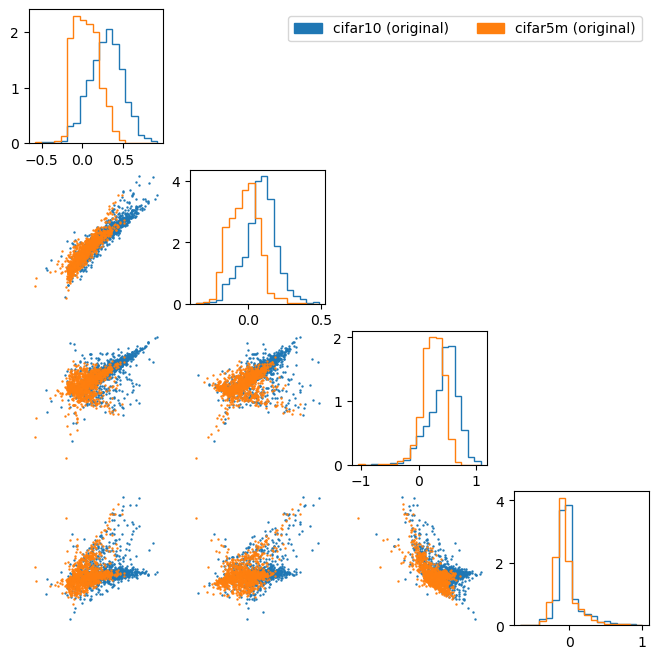

In [36]:
# pre-tune

from utils.plotting import make_corner
sel_label=4
regular = cifar_embeds_pretune[cifar_labels_pretune==sel_label]
shift = cifar5m_test_embed_pretune[cifar5m_test_labels_pretune==sel_label]
make_corner(np.concatenate([regular,shift],axis=0),
            labels=np.concatenate([np.zeros(len(regular)),np.ones(len(shift))]),
            label_names={0:"cifar10 (original)",1:"cifar5m (original)"})

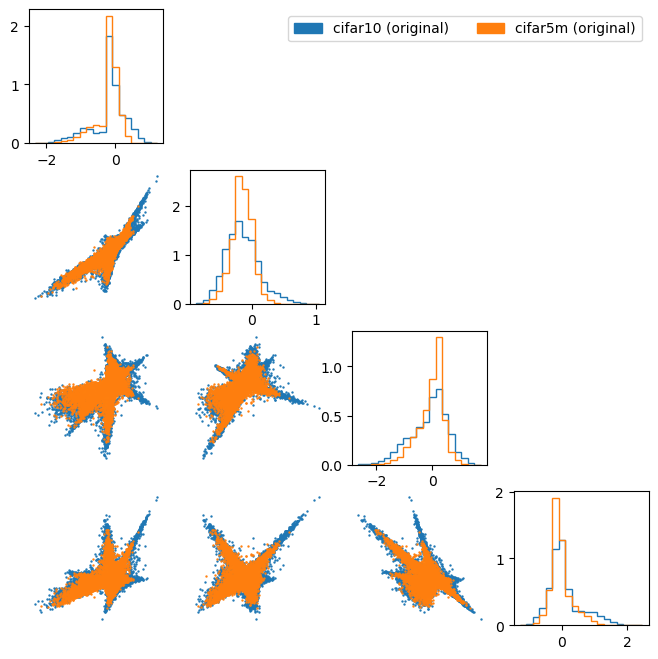

In [37]:
# full space pre-tune

from utils.plotting import make_corner
regular = cifar_embeds_pretune
shift = cifar5m_test_embed_pretune
make_corner(np.concatenate([regular,shift],axis=0),
            labels=np.concatenate([np.zeros(len(regular)),np.ones(len(shift))]),
            label_names={0:"cifar10 (original)",1:"cifar5m (original)"})

Text(0.5, 1.0, 'CIFAR label 5')

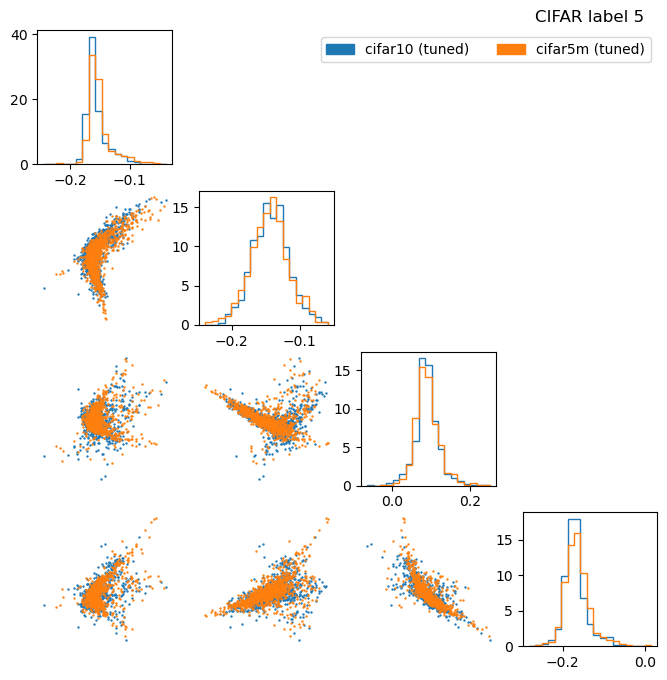

In [38]:
# post-tune

from utils.plotting import make_corner
sel_label=5
regular = cifar_embeds_tune[cifar_labels_tune==sel_label]
shift = cifar5m_test_embed_tune[cifar5m_test_labels_tune==sel_label]
make_corner(np.concatenate([regular,shift],axis=0),
            labels=np.concatenate([np.zeros(len(regular)),np.ones(len(shift))]),
            label_names={0:"cifar10 (tuned)",1:"cifar5m (tuned)"})
plt.title(f"CIFAR label {sel_label}")

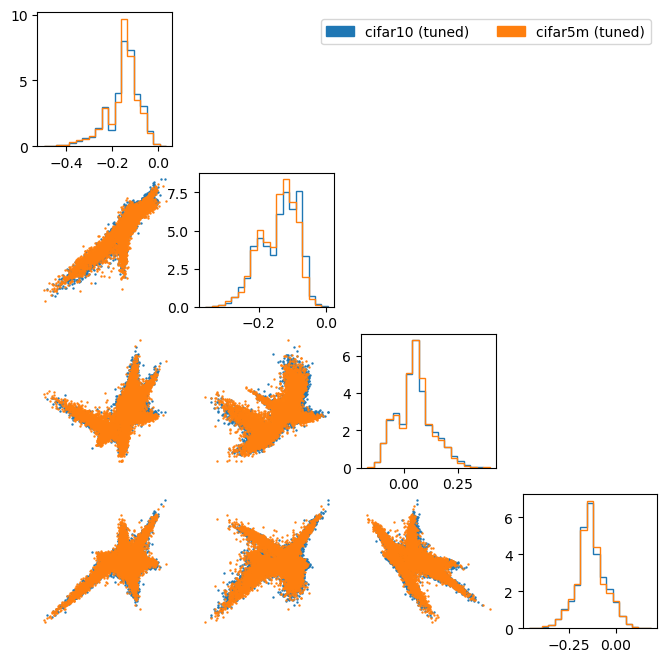

In [39]:
# compare full space
from utils.plotting import make_corner
regular = cifar_embeds_tune
shift = cifar5m_test_embed_tune
make_corner(np.concatenate([regular,shift],axis=0),
            labels=np.concatenate([np.zeros(len(regular)),np.ones(len(shift))]),
            label_names={0:"cifar10 (tuned)",1:"cifar5m (tuned)"})

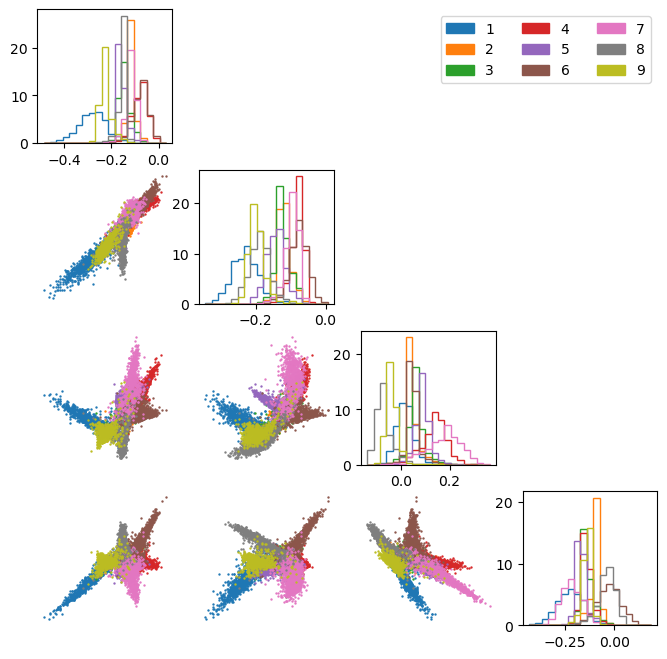

In [40]:
# compare full space
from utils.plotting import make_corner
regular = cifar_embeds_tune
make_corner(regular,
            labels=cifar_labels_tune)

In [41]:
print("Embedding space classifier metrics for CIFAR10 test set")
probs_cifar_tune = F.softmax(torch.tensor(cifar_preds_tune),dim=1).numpy()
auc = roc_auc_score(cifar_labels_tune,probs_cifar_tune,multi_class='ovr')
print("OVR auc = ",auc)
auc = roc_auc_score(cifar_labels_tune,probs_cifar_tune,multi_class='ovo')
print("OVO auc = ",auc)
for k in range(1,6):
    topk = top_k_accuracy_score(cifar_labels_tune,probs_cifar_tune,k=k)
    print(f"Top {k} acc = ",topk)

Embedding space classifier metrics for CIFAR10 test set


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [59]:
print("Embedding space classifier metrics for CIFAR5m tiny set")
probs_cifar5m_test_tune = F.softmax(torch.tensor(cifar5m_test_preds_tune),dim=1).numpy()
auc = roc_auc_score(cifar5m_test_labels_tune,probs_cifar5m_test_tune,multi_class='ovr')
print("OVR auc = ",auc)
auc = roc_auc_score(cifar5m_test_labels_tune,probs_cifar5m_test_tune,multi_class='ovo')
print("OVO auc = ",auc)
for k in range(1,6):
    topk = top_k_accuracy_score(cifar5m_test_labels_tune,probs_cifar5m_test_tune,k=k)
    print(f"Top {k} acc = ",topk)

Embedding space classifier metrics for CIFAR5m tiny set
OVR auc =  0.9490605458408196
OVO auc =  0.9499032055364192
Top 1 acc =  0.6532
Top 2 acc =  0.852
Top 3 acc =  0.9242
Top 4 acc =  0.9472
Top 5 acc =  0.9645


In [42]:
torch.save(model.state_dict(),"model_supervisedTunedTo5m_exclude0.pt")

# Evaluate fine-tuned model; make files for NPLM

In [71]:
model = SimCLRModel.load_from_checkpoint(CHECKPOINT)
tuned_weights = torch.load("model_cifar10tocifar5m.pt")
model.load_state_dict(tuned_weights)
model = model.eval()

/n/holystore01/LABS/iaifi_lab/Users/sambt/mamba/envs/torch_gpu/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/n/holystore01/LABS/iaifi_lab/Users/sambt/mamba/envs/torch_gpu/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.
/n/holystore01/LABS/iaifi_lab/Users/sambt/mamba/envs/torch_gpu/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'classifier' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['classifier'])`.
/tmp/ipykernel_430118/296608810.py:2: F

In [72]:
EXCLUDE_CLASSES = [9]

cifar = CIFAR10Dataset("resnet50",exclude_classes=EXCLUDE_CLASSES,num_workers=2,batch_size=1024)
cifar_train_dataset = cifar.train_dataset
cifar_test_dataset = cifar.test_dataset

In [73]:
# evaluate on cifar10 test set
loader = DataLoader(cifar_test_dataset,batch_size=512,shuffle=True)
embeddings = []
labels = []
for batch in loader:
    x,label = batch
    labels.append(label.numpy())
    with torch.no_grad():
        embeddings.append(model.encoder(x.to(device)).cpu().numpy())
embeddings = np.concatenate(embeddings)
labels = np.concatenate(labels)
np.save("cifar10_test_labels_fineTuned.npy",labels)
np.save("cifar10_test_embeddings_fineTuned.npy",embeddings)

In [90]:
# load in 20k images from cifar5m from an independent set w.r.t. fine tuning
EXCLUDE_CLASSES = [9]
hue_transform = v2.ColorJitter(hue=(-0.2,-0.2))
cifar5m_test = CIFAR5MDataset("resnet50",[1],[(None,50_000)],exclude_classes=EXCLUDE_CLASSES,
                              grayscale=False,custom_pre_transforms=[hue_transform])
labels = sorted(list(set(cifar5m_test.labels)))
num_per = np.min([np.count_nonzero(cifar5m_test.labels==l) for l in labels])
all_indices = np.arange(len(cifar5m_test))
sel_indices = []
for l in labels:
    sel_indices.append(np.argwhere(cifar5m_test.labels==l)[:num_per])
sel_indices = np.concatenate(sel_indices)[:,0]
np.random.shuffle(sel_indices)
cifar5m_test = cifar5m_test.subselection(sel_indices)

In [92]:
# evaluate on cifar10 test set
loader = DataLoader(cifar5m_test,batch_size=512,shuffle=True)
embeddings = []
labels = []
for batch in tqdm(loader):
    x,label = batch
    labels.append(label.numpy())
    with torch.no_grad():
        embeddings.append(model.encoder(x.to(device)).cpu().numpy())
embeddings = np.concatenate(embeddings)
labels = np.concatenate(labels)
np.save("cifar5m_test_labels_fineTuned.npy",labels)
np.save("cifar5m_test_embeddings_fineTuned.npy",embeddings)

100%|██████████| 76/76 [01:09<00:00,  1.10it/s]


In [79]:
# load in 20k images from cifar5m from an independent set w.r.t. fine tuning
EXCLUDE_CLASSES = [0,1,2,3,4,5,6,7,8]
hue_transform = v2.ColorJitter(hue=(-0.2,-0.2))
cifar5m_anomaly = CIFAR5MDataset("resnet50",[1],[(None,120_000)],exclude_classes=EXCLUDE_CLASSES,
                              grayscale=False,custom_pre_transforms=[hue_transform])

In [81]:
# evaluate on cifar10 test set
loader = DataLoader(cifar5m_anomaly,batch_size=512,shuffle=True)
embeddings = []
labels = []
for batch in tqdm(loader):
    x,label = batch
    labels.append(label.numpy())
    with torch.no_grad():
        embeddings.append(model.encoder(x.to(device)).cpu().numpy())
embeddings = np.concatenate(embeddings)
labels = np.concatenate(labels)
np.save("cifar5m_anomaly_labels_fineTuned.npy",labels)
np.save("cifar5m_anomaly_embeddings_fineTuned.npy",embeddings)

100%|██████████| 23/23 [00:21<00:00,  1.09it/s]


# Evaluate original model for NPLM comparison

In [3]:
model = SimCLRModel.load_from_checkpoint(CHECKPOINT)
model = model.eval()

/n/holystore01/LABS/iaifi_lab/Users/sambt/mamba/envs/torch_gpu/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/n/holystore01/LABS/iaifi_lab/Users/sambt/mamba/envs/torch_gpu/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.
/n/holystore01/LABS/iaifi_lab/Users/sambt/mamba/envs/torch_gpu/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'classifier' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['classifier'])`.


In [4]:
EXCLUDE_CLASSES = [9]

cifar = CIFAR10Dataset("resnet50",exclude_classes=EXCLUDE_CLASSES,num_workers=2,batch_size=1024)
cifar_train_dataset = cifar.train_dataset
cifar_test_dataset = cifar.test_dataset

In [5]:
# evaluate on cifar10 test set
loader = DataLoader(cifar_test_dataset,batch_size=512,shuffle=True)
embeddings = []
labels = []
for batch in loader:
    x,label = batch
    labels.append(label.numpy())
    with torch.no_grad():
        embeddings.append(model.encoder(x.to(device)).cpu().numpy())
embeddings = np.concatenate(embeddings)
labels = np.concatenate(labels)
np.save("cifar10_test_labels_unTuned.npy",labels)
np.save("cifar10_test_embeddings_unTuned.npy",embeddings)

In [6]:
# load in 20k images from cifar5m from an independent set w.r.t. fine tuning
EXCLUDE_CLASSES = [9]
hue_transform = v2.ColorJitter(hue=(-0.2,-0.2))
cifar5m_test = CIFAR5MDataset("resnet50",[1],[(None,50_000)],exclude_classes=EXCLUDE_CLASSES,
                              grayscale=False,custom_pre_transforms=[hue_transform])
labels = sorted(list(set(cifar5m_test.labels)))
num_per = np.min([np.count_nonzero(cifar5m_test.labels==l) for l in labels])
all_indices = np.arange(len(cifar5m_test))
sel_indices = []
for l in labels:
    sel_indices.append(np.argwhere(cifar5m_test.labels==l)[:num_per])
sel_indices = np.concatenate(sel_indices)[:,0]
np.random.shuffle(sel_indices)
cifar5m_test = cifar5m_test.subselection(sel_indices)

In [7]:
# evaluate on cifar10 test set
loader = DataLoader(cifar5m_test,batch_size=512,shuffle=True)
embeddings = []
labels = []
for batch in tqdm(loader):
    x,label = batch
    labels.append(label.numpy())
    with torch.no_grad():
        embeddings.append(model.encoder(x.to(device)).cpu().numpy())
embeddings = np.concatenate(embeddings)
labels = np.concatenate(labels)
np.save("cifar5m_test_labels_unTuned.npy",labels)
np.save("cifar5m_test_embeddings_unTuned.npy",embeddings)

100%|██████████| 76/76 [01:12<00:00,  1.05it/s]


In [8]:
# load in 20k images from cifar5m from an independent set w.r.t. fine tuning
EXCLUDE_CLASSES = [0,1,2,3,4,5,6,7,8]
hue_transform = v2.ColorJitter(hue=(-0.2,-0.2))
cifar5m_anomaly = CIFAR5MDataset("resnet50",[1],[(None,120_000)],exclude_classes=EXCLUDE_CLASSES,
                              grayscale=False,custom_pre_transforms=[hue_transform])

In [9]:
# evaluate on cifar10 test set
loader = DataLoader(cifar5m_anomaly,batch_size=512,shuffle=True)
embeddings = []
labels = []
for batch in tqdm(loader):
    x,label = batch
    labels.append(label.numpy())
    with torch.no_grad():
        embeddings.append(model.encoder(x.to(device)).cpu().numpy())
embeddings = np.concatenate(embeddings)
labels = np.concatenate(labels)
np.save("cifar5m_anomaly_labels_unTuned.npy",labels)
np.save("cifar5m_anomaly_embeddings_unTuned.npy",embeddings)

100%|██████████| 23/23 [00:22<00:00,  1.02it/s]
